# Practical 9
Apply k-means and hierarchical clustering on a dataset such as customer segmentation, visualise the resulting clusters, and validate the results using silhouette scores. Use manual functions for all steps.

## Load and preprocess data

Load a suitable dataset for customer segmentation and perform necessary preprocessing steps, such as scaling or normalization.


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import io

csv_data = """CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
6,Female,22,17,76
7,Female,35,18,6
8,Female,23,18,94
9,Male,64,19,3
10,Female,30,19,72
11,Male,67,19,14
12,Female,35,19,99
13,Female,58,20,15
14,Female,24,20,77
15,Male,37,20,13
16,Male,22,20,79
17,Female,35,21,35
18,Male,20,21,66
19,Male,52,21,29
20,Female,35,21,98
"""

df = pd.read_csv(io.StringIO(csv_data))

# Identify relevant features (Annual Income and Spending Score are good candidates for customer segmentation)
features = ['Annual Income (k$)', 'Spending Score (1-100)']
X = df[features]

# Check for missing values
print("Missing values before handling:")
print(X.isnull().sum())

# Scale the selected features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Store the preprocessed data in a new DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

print("\nPreprocessed data (scaled):")
display(X_scaled_df.head())

Missing values before handling:
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Preprocessed data (scaled):


,Annual Income (k$),Spending Score (1-100)
0,-1.837117,-0.359028
1,-1.837117,0.902827
2,-1.326807,-1.350485
3,-1.326807,0.782650
4,-0.816497,-0.328984


## Implement k-means clustering

Implement the K-Means algorithm manually (without using scikit-learn's `KMeans` class) and apply it to the preprocessed data.


In [2]:
import numpy as np

def euclidean_distance(point1, point2):
  """Calculates the Euclidean distance between two points."""
  return np.sqrt(np.sum((point1 - point2)**2))

def initialize_centroids(data, k):
  """Initializes k random centroids from the data."""
  indices = np.random.choice(len(data), k, replace=False)
  return data[indices]

def assign_to_clusters(data, centroids):
  """Assigns each data point to the nearest centroid."""
  assignments = []
  for point in data:
    distances = [euclidean_distance(point, centroid) for centroid in centroids]
    assignments.append(np.argmin(distances))
  return np.array(assignments)

def update_centroids(data, assignments, k):
  """Updates the centroids based on the mean of assigned data points."""
  new_centroids = []
  for i in range(k):
    cluster_points = data[assignments == i]
    if len(cluster_points) > 0:
      new_centroids.append(np.mean(cluster_points, axis=0))
    else:
      # If a cluster is empty, reinitialize its centroid
      new_centroids.append(initialize_centroids(data, 1)[0])
  return np.array(new_centroids)

def kmeans(data, k, max_iterations=100):
  """Manual implementation of the K-Means algorithm."""
  data_np = data.values # Convert DataFrame to NumPy array for easier manipulation
  centroids = initialize_centroids(data_np, k)

  for _ in range(max_iterations):
    assignments = assign_to_clusters(data_np, centroids)
    new_centroids = update_centroids(data_np, assignments, k)

    if np.allclose(centroids, new_centroids):
      break # Convergence
    centroids = new_centroids

  return centroids, assignments

# Apply K-Means to the scaled data with 5 clusters
k = 5
final_centroids, kmeans_labels = kmeans(X_scaled_df, k)

print("Final Centroids:")
print(final_centroids)

print("\nFirst 20 Cluster Assignments:")
print(kmeans_labels[:20])

Final Centroids:
[[ 0.96958969  0.87278273]
 [-0.81649658 -0.32898351]
 [-0.40824829  0.98094169]
 [ 0.56863155 -1.03716719]
 [-1.66701385 -0.2688952 ]]

First 20 Cluster Assignments:
[4 4 4 2 1 2 3 2 3 2 3 2 3 0 3 0 3 0 3 0]


## Implement hierarchical clustering

Implement the Hierarchical clustering algorithm manually (without using scikit-learn's `AgglomerativeClustering` class) and apply it to the preprocessed data.


In [3]:
def euclidean_distance(point1, point2):
  """Calculates the Euclidean distance between two points."""
  return np.sqrt(np.sum((point1 - point2)**2))

def single_linkage(cluster1, cluster2):
  """Calculates the single linkage distance between two clusters."""
  min_distance = float('inf')
  for p1 in cluster1:
    for p2 in cluster2:
      dist = euclidean_distance(p1, p2)
      if dist < min_distance:
        min_distance = dist
  return min_distance

def hierarchical_clustering(data, k):
  """Manual implementation of hierarchical clustering (Agglomerative)."""
  data_np = data.values
  n_samples = data_np.shape[0]

  # Initialize each data point as its own cluster
  clusters = [[i] for i in range(n_samples)]
  cluster_assignments = list(range(n_samples)) # Initial assignment

  # Store merge history for later use (optional, for dendrogram)
  # merge_history = []

  # Repeatedly merge the two closest clusters
  while len(clusters) > k:
    min_dist = float('inf')
    merge_indices = (-1, -1)

    # Find the closest pair of clusters
    for i in range(len(clusters)):
      for j in range(i + 1, len(clusters)):
        dist = single_linkage(data_np[clusters[i]], data_np[clusters[j]])
        if dist < min_dist:
          min_dist = dist
          merge_indices = (i, j)

    # Merge the two closest clusters
    c1_idx, c2_idx = merge_indices
    merged_cluster = clusters[c1_idx] + clusters[c2_idx]

    # Update cluster assignments for the merged points
    for point_idx in merged_cluster:
      cluster_assignments[point_idx] = len(clusters) - 1 # Assign to the new cluster index

    # Add the merged cluster and remove the original two
    clusters.append(merged_cluster)
    clusters.pop(max(c1_idx, c2_idx)) # Remove in decreasing order to avoid index issues
    clusters.pop(min(c1_idx, c2_idx))

    # Update cluster assignments to reflect the removed clusters (re-index)
    old_indices = sorted([max(c1_idx, c2_idx), min(c1_idx, c2_idx)])
    for i in range(len(cluster_assignments)):
        if cluster_assignments[i] == old_indices[0]:
            cluster_assignments[i] = len(clusters) - 1
        elif cluster_assignments[i] == old_indices[1]:
            cluster_assignments[i] = len(clusters) - 1
        elif cluster_assignments[i] > old_indices[1]:
            cluster_assignments[i] -= 2
        elif cluster_assignments[i] > old_indices[0]:
            cluster_assignments[i] -= 1


  # After merging down to k clusters, finalize assignments
  final_assignments = np.zeros(n_samples, dtype=int)
  for cluster_idx, point_indices in enumerate(clusters):
      for point_idx in point_indices:
          final_assignments[point_idx] = cluster_idx

  return final_assignments

# Apply hierarchical clustering to the scaled data with 5 clusters
hierarchical_labels = hierarchical_clustering(X_scaled_df, k)

print("First 20 Hierarchical Cluster Assignments:")
print(hierarchical_labels[:20])

First 20 Hierarchical Cluster Assignments:
[0 4 1 4 2 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4]


## Visualize clusters

Visualize the clusters obtained from both K-Means and Hierarchical clustering using scatter plots or other appropriate visualization techniques.


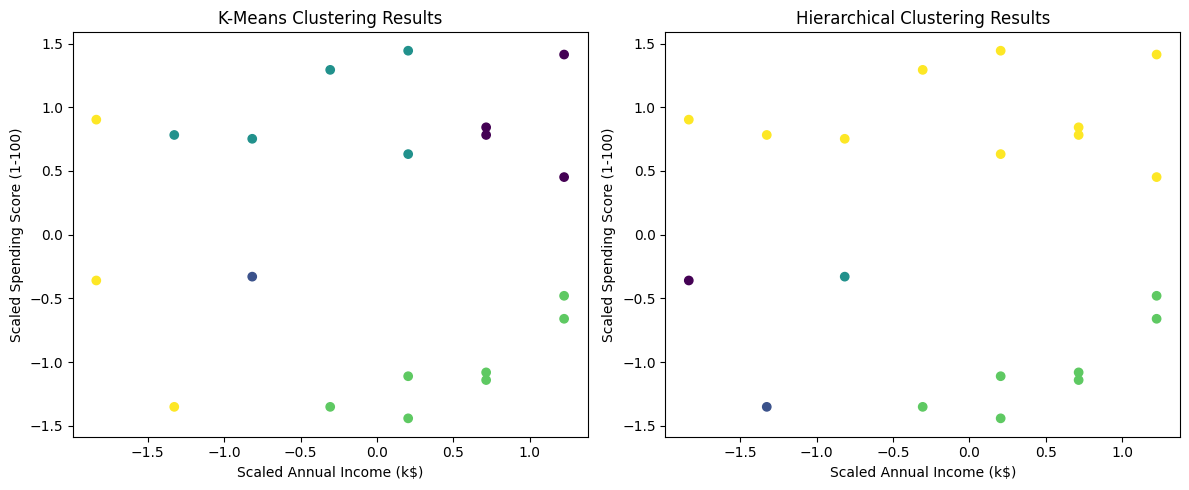

In [4]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for K-Means clustering results
axes[0].scatter(X_scaled_df.iloc[:, 0], X_scaled_df.iloc[:, 1], c=kmeans_labels, cmap='viridis')
axes[0].set_title('K-Means Clustering Results')
axes[0].set_xlabel('Scaled Annual Income (k$)')
axes[0].set_ylabel('Scaled Spending Score (1-100)')

# Scatter plot for Hierarchical clustering results
axes[1].scatter(X_scaled_df.iloc[:, 0], X_scaled_df.iloc[:, 1], c=hierarchical_labels, cmap='viridis')
axes[1].set_title('Hierarchical Clustering Results')
axes[1].set_xlabel('Scaled Annual Income (k$)')
axes[1].set_ylabel('Scaled Spending Score (1-100)')

# Display the plots
plt.tight_layout()
plt.show()

## Implement silhouette score

Implement the Silhouette Score calculation manually (without using scikit-learn's `silhouette_score` function) to evaluate the quality of the clusters.


In [5]:
import numpy as np

def euclidean_distance(point1, point2):
  """Calculates the Euclidean distance between two points."""
  return np.sqrt(np.sum((point1 - point2)**2))

def calculate_silhouette_score(data, labels):
    """
    Calculates the silhouette score for a clustering.

    Args:
        data: A NumPy array or pandas DataFrame of the data points.
        labels: A NumPy array or list of cluster labels for each data point.

    Returns:
        The average silhouette score.
    """
    data_np = data.values if isinstance(data, pd.DataFrame) else data
    n_samples = len(data_np)
    silhouette_coefficients = []

    for i in range(n_samples):
        # Step 4: Calculate a (average distance to other points in the same cluster)
        current_label = labels[i]
        same_cluster_indices = [j for j in range(n_samples) if labels[j] == current_label and j != i]

        if not same_cluster_indices:
            a = 0 # Cluster contains only one point
        else:
            distances_to_same_cluster = [euclidean_distance(data_np[i], data_np[j]) for j in same_cluster_indices]
            a = np.mean(distances_to_same_cluster)

        # Step 5: Calculate b (minimum average distance to points in other clusters)
        other_clusters_labels = set(labels) - {current_label}
        b = float('inf')

        for other_label in other_clusters_labels:
            other_cluster_indices = [j for j in range(n_samples) if labels[j] == other_label]
            if other_cluster_indices:
                distances_to_other_cluster = [euclidean_distance(data_np[i], data_np[j]) for j in other_cluster_indices]
                avg_distance_to_other_cluster = np.mean(distances_to_other_cluster)
                if avg_distance_to_other_cluster < b:
                    b = avg_distance_to_other_cluster

        # Step 6: Calculate the silhouette coefficient
        if max(a, b) == 0: # Handle cases where a and b are both 0 (e.g., single point or all points are the same)
            silhouette_coefficient = 0
        else:
            silhouette_coefficient = (b - a) / max(a, b)

        silhouette_coefficients.append(silhouette_coefficient)

    # Step 7: Calculate the average silhouette score
    average_silhouette_score = np.mean(silhouette_coefficients)

    return average_silhouette_score

# Calculate silhouette scores for K-Means and Hierarchical clustering
kmeans_silhouette_score = calculate_silhouette_score(X_scaled_df, kmeans_labels)
hierarchical_silhouette_score = calculate_silhouette_score(X_scaled_df, hierarchical_labels)

print(f"Silhouette Score for K-Means Clustering: {kmeans_silhouette_score}")
print(f"Silhouette Score for Hierarchical Clustering: {hierarchical_silhouette_score}")

Silhouette Score for K-Means Clustering: 0.29423818800093554
Silhouette Score for Hierarchical Clustering: 0.38066612141904044


## Evaluate and compare

Calculate the Silhouette Scores for both K-Means and Hierarchical clustering results and compare them to determine which algorithm performed better.


In [6]:
print("\n--- Comparison of Silhouette Scores ---")
if kmeans_silhouette_score > hierarchical_silhouette_score:
  print(f"K-Means Clustering performed better with a Silhouette Score of: {kmeans_silhouette_score:.4f}")
elif hierarchical_silhouette_score > kmeans_silhouette_score:
  print(f"Hierarchical Clustering performed better with a Silhouette Score of: {hierarchical_silhouette_score:.4f}")
else:
  print("Both K-Means and Hierarchical Clustering have the same Silhouette Score.")

print("------------------------------------")


--- Comparison of Silhouette Scores ---
Hierarchical Clustering performed better with a Silhouette Score of: 0.3807
------------------------------------
